In [1]:
%pip install yfinance
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import datetime

In [4]:
import yfinance as yf
import pandas as pd

# Download Dow Jones (^DJI)
df = yf.download("^DJI", start="2009-12-31", end="2025-12-28")

# Flatten MultiIndex columns if they exist
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Reset index so 'Date' becomes a column
df.reset_index(inplace=True)

# Add Ticker column
df["Ticker"] = "^DJI"

# Ensure numeric columns are floats (only if they exist)
numeric_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
existing_numeric_cols = [col for col in numeric_cols if col in df.columns]
df[existing_numeric_cols] = df[existing_numeric_cols].apply(pd.to_numeric, errors='coerce')

# Reorder columns neatly (only include columns that exist)
final_cols = ["Date", "Ticker"] + [col for col in numeric_cols if col in df.columns]
df = df[final_cols]

print(df.head())

C:\Users\adars\AppData\Local\Temp\ipykernel_116892\439205325.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^DJI", start="2009-12-31", end="2025-12-28")
[*********************100%***********************]  1 of 1 completed

        Date Ticker          Open          High           Low         Close  \
0 2009-12-31   ^DJI  10548.509766  10555.009766  10423.129883  10428.049805   
1 2010-01-04   ^DJI  10430.690430  10604.969727  10430.690430  10583.959961   
2 2010-01-05   ^DJI  10584.559570  10584.559570  10522.519531  10572.019531   
3 2010-01-06   ^DJI  10564.719727  10594.990234  10546.549805  10573.679688   
4 2010-01-07   ^DJI  10571.110352  10612.370117  10505.209961  10606.860352   

      Volume  
0  137940000  
1  179780000  
2  188540000  
3  186040000  
4  217390000  


In [5]:
df.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2009-12-31,^DJI,10548.509766,10555.009766,10423.129883,10428.049805,137940000
1,2010-01-04,^DJI,10430.690430,10604.969727,10430.690430,10583.959961,179780000
2,2010-01-05,^DJI,10584.559570,10584.559570,10522.519531,10572.019531,188540000
3,2010-01-06,^DJI,10564.719727,10594.990234,10546.549805,10573.679688,186040000
4,2010-01-07,^DJI,10571.110352,10612.370117,10505.209961,10606.860352,217390000


In [6]:
df.shape

(3961, 7)

### Close Price over time

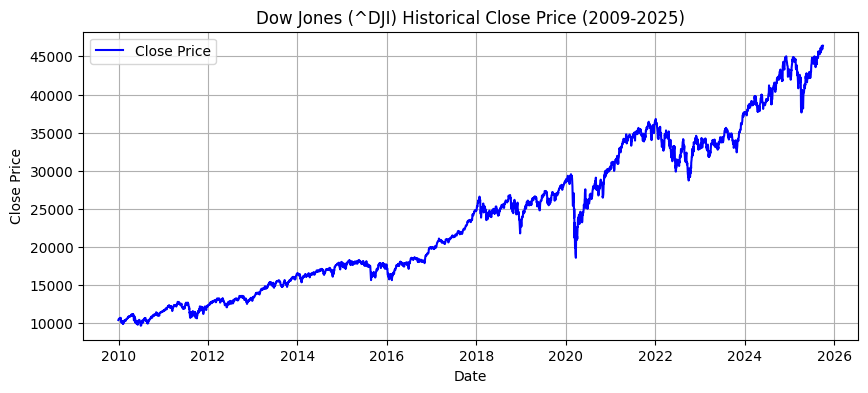

In [7]:
# Plotting the Close price over time
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.title("Dow Jones (^DJI) Historical Close Price (2009-2025)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
maxPrice = df['Close'].max()
minPrice = df['Close'].min()
print(f"Max Close Price: {maxPrice}, Min Close Price: {minPrice}")

Max Close Price: 46397.890625, Min Close Price: 9686.48046875


### OHLC plot

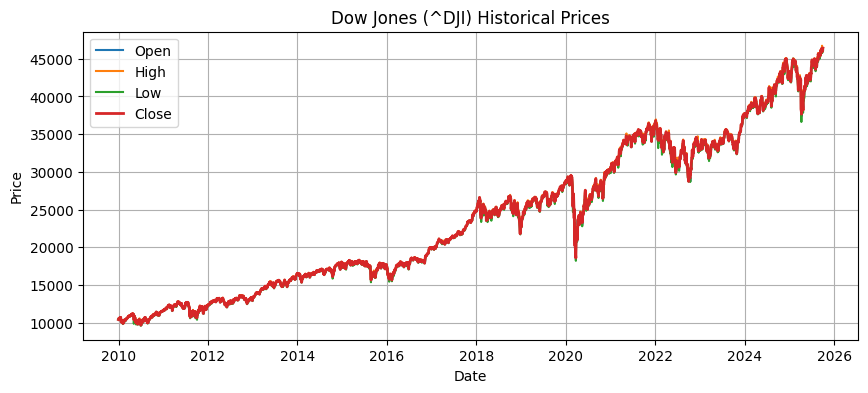

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['High'], label='High')
plt.plot(df['Date'], df['Low'], label='Low')
plt.plot(df['Date'], df['Close'], label='Close', linewidth=2)
plt.title("Dow Jones (^DJI) Historical Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Moving Average Plot over 50 and 200 Days

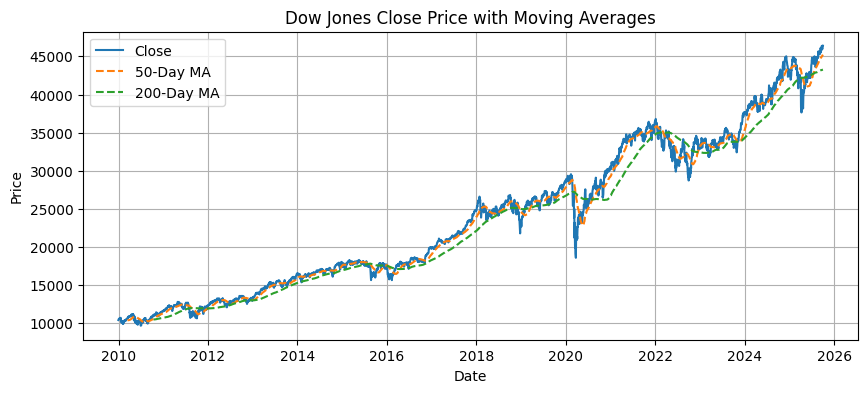

In [10]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', linestyle='--')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', linestyle='--')
plt.title("Dow Jones Close Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
%pip install mplfinance
import mplfinance as mpf

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
df_new = df[(df['Date'] >= '2019-12-01') & (df['Date'] <= '2021-07-28')]
df_new.set_index('Date', inplace=True)

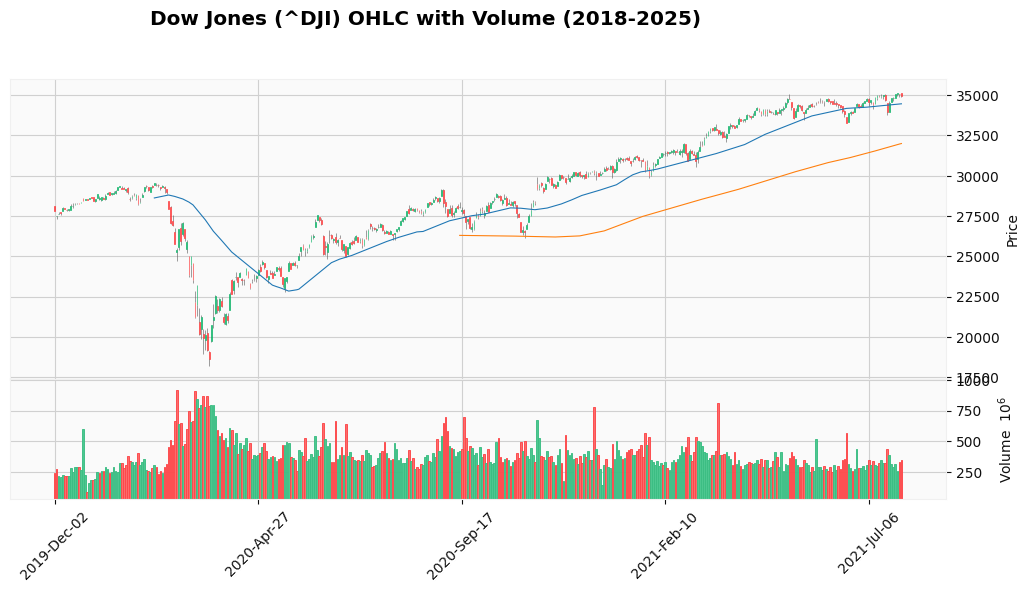

In [13]:
# Plot candlestick chart
mpf.plot(df_new, 
         type='candle', 
         style='yahoo', 
         volume=True, 
         title="Dow Jones (^DJI) OHLC with Volume (2018-2025)", 
         mav=(50,200), 
         figsize=(13,6))

### Normalizing and Scaling the Data

In [14]:
# Use only 'Close' column
data = df['Close'].values.reshape(-1,1)

# Normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [15]:
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

### LSTM Sequence

In [16]:
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape input to [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Building LSTM

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))  # Predict next closing price

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\adars\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)

Epoch 1/10


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.9245e-04
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.8882e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.9467e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7725e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.7169e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.4962e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.5390e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.2346e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1862e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0844e-04


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling to original prices
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))

test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

### Metric analysis

In [ ]:
# y_test_actual → actual prices (inverse transformed)
# test_predict → predicted prices (inverse transformed)

mse = mean_squared_error(y_test_actual, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_predict)
r2 = r2_score(y_test_actual, test_predict)

print("Model Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation on Test Data:
Mean Squared Error (MSE): 325288.9802
Root Mean Squared Error (RMSE): 570.3411
Mean Absolute Error (MAE): 476.5104
R² Score: 0.9818


In [ ]:
# # Plot actual vs predicted
# plt.figure(figsize=(15,6))
# plt.plot(df['Date'], data, label='Actual Price')
# # Plotting predicted prices for test set
# plt.plot(df['Date'][training_size+time_step:], test_predict, label='Predicted Price', color='red')
# plt.title('Dow Jones Price Prediction (LSTM)')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.show()

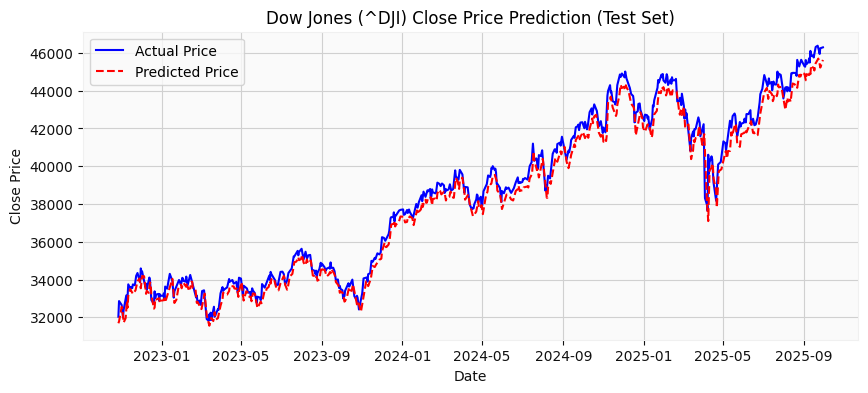

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a range for the test data
test_dates = df['Date'][training_size + time_step:]  # Adjust index for time_step offset

plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue')
plt.plot(test_dates, test_predict, label='Predicted Price', color='red', linestyle='--')
plt.title("Dow Jones (^DJI) Close Price Prediction (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


## RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

Sequence for RNN

In [ ]:
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape input to [samples, time steps, features] for RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
model = Sequential()
model.add(SimpleRNN(50, activation='tanh', input_shape=(time_step,1)))
model.add(Dense(25))
model.add(Dense(1))  # Predict next closing price

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\adars\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0835e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5766e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7657e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1421e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0103e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0089e-04
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2845e-05
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7008e-05
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9230e-05
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9159e-05
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0851e-05
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9954e-05
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1533e-05
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))

test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


mse = mean_squared_error(y_test_actual, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_predict)
r2 = r2_score(y_test_actual, test_predict)

print("RNN Model Evaluation on Test Data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RNN Model Evaluation on Test Data:
MSE: 152184.9092
RMSE: 390.1088
MAE: 287.4152
R² Score: 0.9915


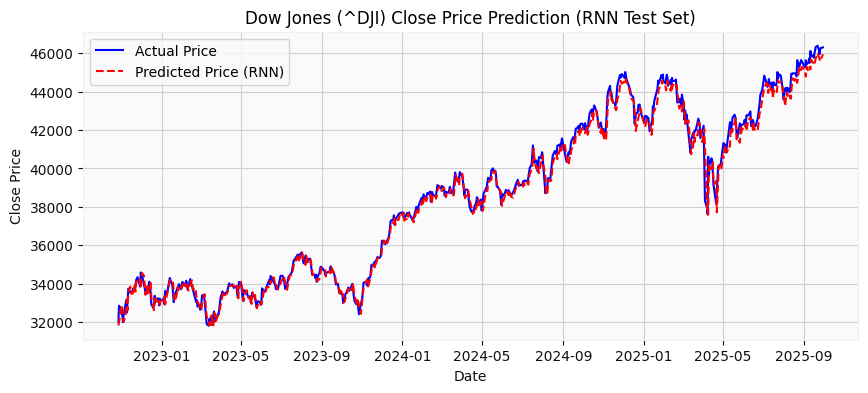

In [ ]:
test_dates = df['Date'][training_size + time_step:]

plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue')
plt.plot(test_dates, test_predict, label='Predicted Price (RNN)', color='red', linestyle='--')
plt.title("Dow Jones (^DJI) Close Price Prediction (RNN Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

## Reservior Computing

In [ ]:
! git clone https://github.com/sunone5/pyESN/

fatal: destination path 'pyESN' already exists and is not an empty directory.


In [ ]:
from pyESN.pyESN import ESN

In [ ]:
# Prepare input-output sequences for ESN
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reservoir Computing requires 2D arrays [samples, features]
# We'll flatten each sequence for ESN input
X_train_esn = X_train
X_test_esn = X_test

# Initialize Echo State Network
esn = ESN(
    n_inputs=time_step,
    n_outputs=1,
    n_reservoir=1000,
    sparsity=0.4,
    random_state=42,
    spectral_radius=0.9,
    noise=1e-6
)

# Train ESN
# Train
esn.fit(X_train_esn, y_train)

# Predict
y_train_pred = esn.predict(X_train_esn)
y_test_pred = esn.predict(X_test_esn)


### Transform and Evaluation

In [ ]:
# Inverse transform
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_train_pred_actual = scaler.inverse_transform(y_train_pred.reshape(-1,1))

y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_test_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1,1))

# Evaluation
mse = mean_squared_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
r2 = r2_score(y_test_actual, y_test_pred_actual)

ESN (Reservoir Computing) Model Evaluation on Test Data:
MSE: 1595939.5525
RMSE: 1263.3050
MAE: 827.3630
R² Score: 0.9108


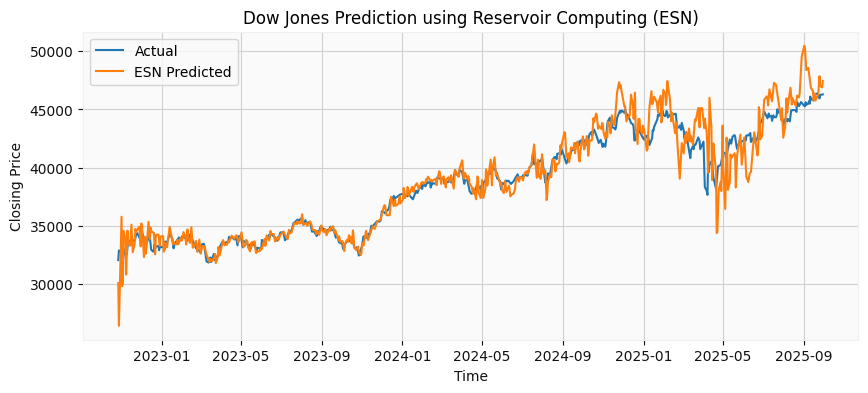

In [ ]:
print("ESN (Reservoir Computing) Model Evaluation on Test Data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test_actual, label="Actual")
plt.plot(test_dates, y_test_pred_actual, label="ESN Predicted")
plt.title("Dow Jones Prediction using Reservoir Computing (ESN)")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()